# "Colorless" Artificial Reverbation
[Allpass filter from 1961 IRE paper by M. R. Schroeder and B. F. Logan](http://www2.ece.rochester.edu/courses/ECE472/resources/Papers/Schroeder_1961.pdf)


Allpass reverb from 1962 JAES paper *Natural Sounding Artificial Reverberation* by M. R. Schroeder

In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift, rfft, rfftfreq
from scipy.io import wavfile

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = [5.333, 3]
plt.rcParams['font.sans-serif'] = ['Tahoma', 'DejaVu Sans','Lucida Grande', 'Verdana']

TAU = 2 * np.pi  

![Allpass Delay](img/allpass_filter.png)

In [2]:
class Delay:
    """Circular buffer delay"""
    def __init__(self, sample_rate, delay_ms, delay_samples=None):
        if delay_samples:
            self.delay_length = delay_samples
        else:
            self.delay_length = int(delay_ms * (sample_rate / 1000.0))
        self.delay_line = deque(np.zeros(self.delay_length), self.delay_length)
        self.output = 0.0

    def tick(self, sample):
        """Run delay for 1 sample"""
        self.output = self.delay_line[-1]
        self.delay_line.appendleft(sample)

    def clear(self):
        """Flush delay line, setting all values to 0.0"""
        for _index in range(self.delay_length + 1):
            self.delay_line.appendleft(0.0)


class CombFilter:
    """Comb filter"""
    def __init__(self, sample_rate, delay_ms, coeff):
        self.delay = Delay(sample_rate, delay_ms)
        self.coeff = coeff
        self.output = 0.0

    def tick(self, sample):
        """Run delay for 1 sample"""
        delay_input = sample + self.coeff * self.delay.output
        self.output = self.delay.output

        self.delay.tick(delay_input)

    def clear(self):
        """Flush delay line, setting all values to 0.0"""
        self.delay.clear()


class AllPassDelay(CombFilter):
    """All pass delay"""
    def tick(self, sample):
        """Run delay for 1 sample"""
        delay_input = sample + self.coeff * self.delay.output
        self.output = ((-1.0 * self.coeff * delay_input) +
                       ((1.0 - self.coeff**2) * self.delay.output))

        self.delay.tick(delay_input)


![Schroeder Reverb](img/schroeder_reverb.png)

In [3]:
class SchroederReverb:
    """Schroeder reverbator, as described in Natural Sounding Artificial Reverberation, Fig. 5"""
    def __init__(self, gain_1, gain_2, delay_length, allpass_matrix, sample_rate):
        self.size = len(allpass_matrix)
        self.gain_1 = gain_1
        self.gain_2 = gain_2
        self.output = 0.0

        self.allpass_reverb = [AllPassDelay(sample_rate, allpass_matrix[allpass][0],
                               allpass_matrix[allpass][1]) for allpass in range(self.size)]

        self.delay = Delay(sample_rate, delay_length)

    def tick(self, input):
        """Run reverb for 1 sample"""
        self.delay.tick(input + self.gain_2 * self.allpass_reverb[-1].output)
        for index, allpass in enumerate(self.allpass_reverb):
            if index == 0:
                allpass.tick(self.delay.output)
            else:
                allpass.tick(self.allpass_reverb[index - 1].output)

        self.output = (self.allpass_reverb[-1].output * (1.0 - self.gain_1**2)) + (input * self.gain_1 * -1.0)
    
    def clear(self):
        """Flush delay lines, setting all values to 0.0"""
        self.delay.clear()
        for allpass in self.allpass_reverb:
            allpass.clear()

In [4]:
delay_length = 43
allpass_matrix = [[100, 0.5],
                  [68, -0.5],
                  [60, 0.5],
                  [19.7, 0.5],
                  [5.85, 0.5]]

sample_rate, input = wavfile.read("./input.wav")

reverb = SchroederReverb(0.33, 1.5, delay_length, allpass_matrix, sample_rate)

output = np.zeros(input.size)

for index, sample in enumerate(input):
    reverb.tick(sample)
    output[index] = reverb.output

wavfile.write("./output.wav", sample_rate, output.astype(np.int16))


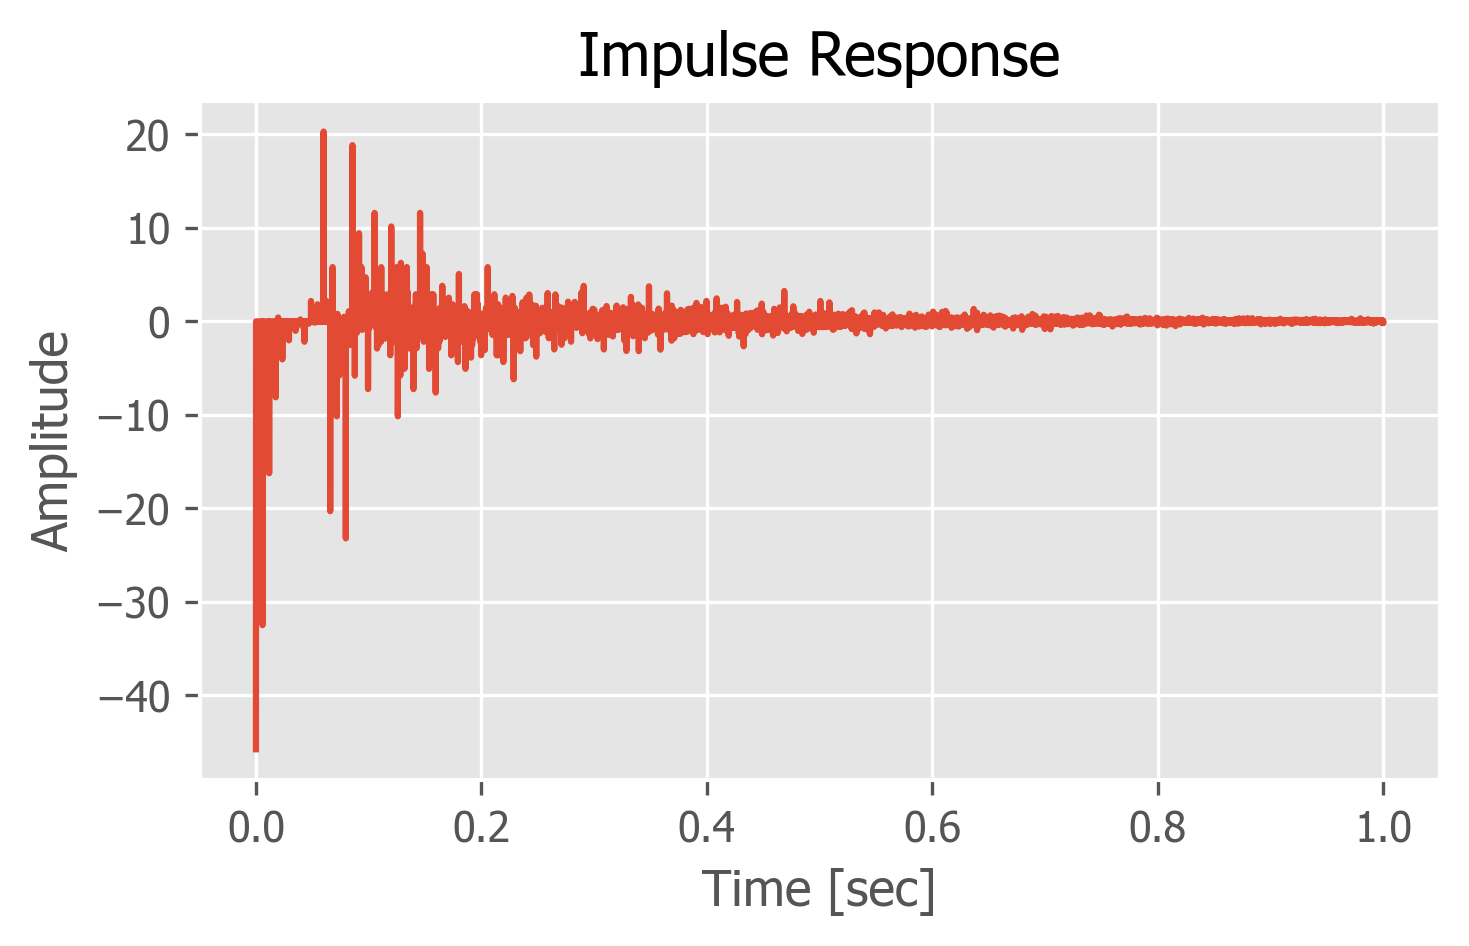

In [5]:
reverb.clear()

time = 1.0
samples = int(time * sample_rate)
x = np.linspace(0.0, time, samples, endpoint=False)
input = signal.unit_impulse(x.size)

output = np.zeros(input.size)
for index, sample in enumerate(input):
    reverb.tick(sample)
    output[index] = reverb.output

plt.plot(x, output)
plt.title('Impulse Response')
plt.xlabel('Time [sec]')
plt.ylabel('Amplitude')
plt.show()

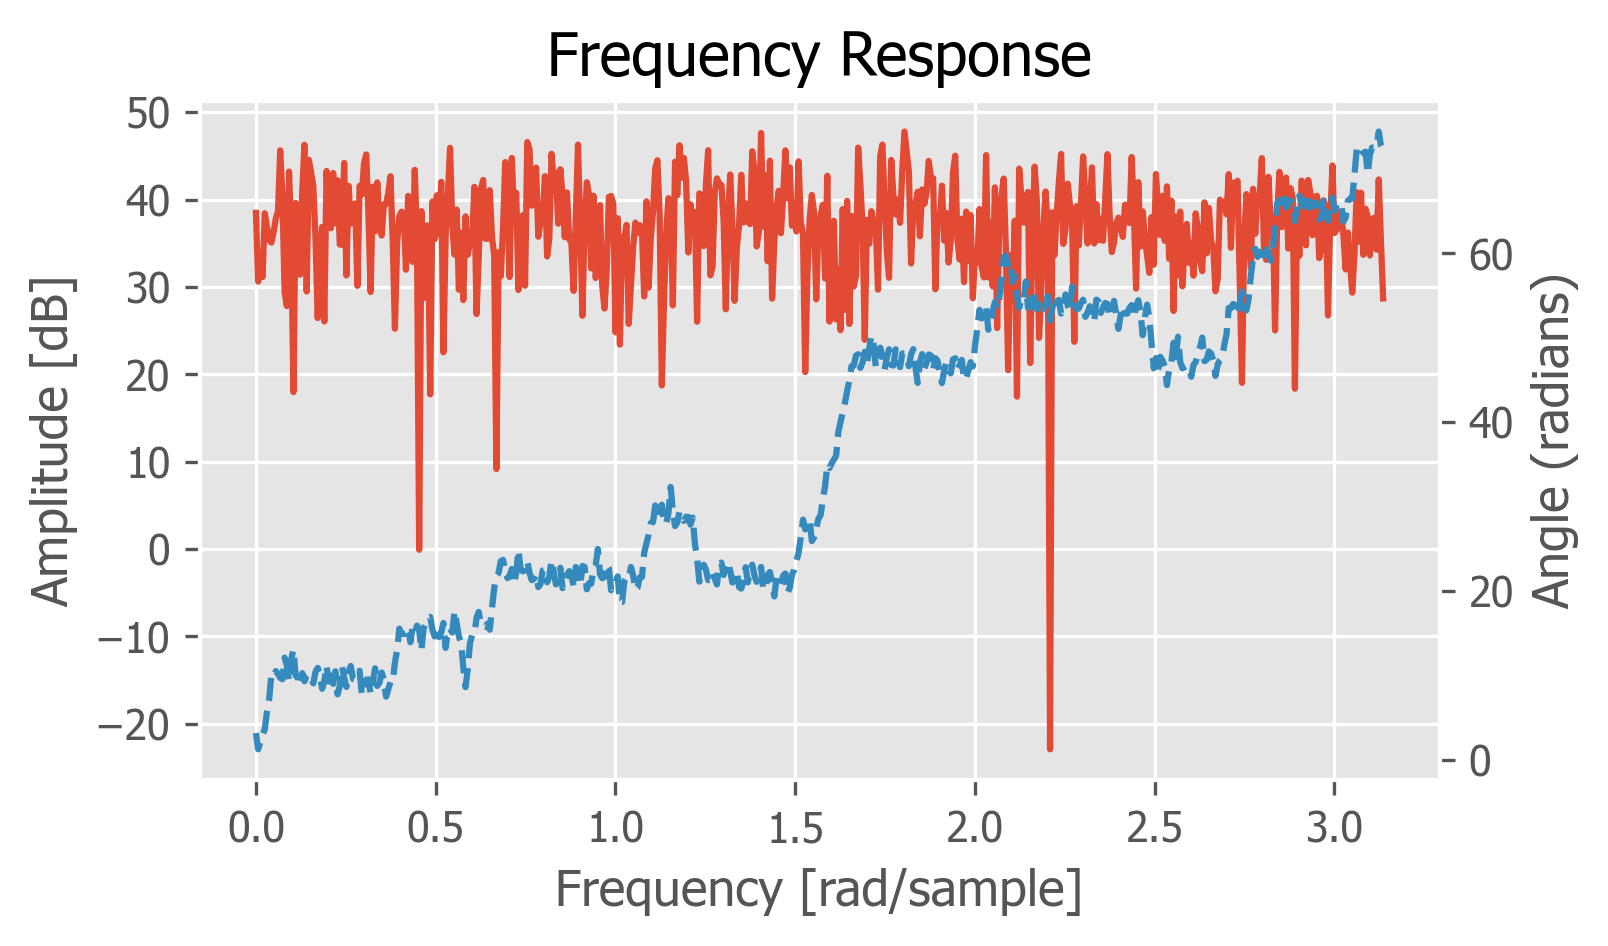

In [6]:
w, h = signal.freqz(output)
fig, ax1 = plt.subplots()

ax1.set_title('Frequency Response')
ax1.plot(w, 20 * np.log10(abs(h)), 'C0-')
ax1.set_ylabel('Amplitude [dB]')
ax1.set_xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles,'C1--')
ax2.set_ylabel('Angle (radians)')
ax2.grid()
ax2.axis('tight')

plt.show()